<a href="https://colab.research.google.com/github/SeWonKwon/face-recognition-with-yolov4/blob/main/face_recognition_with_yolov4_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step1. yolov4 환경 구축

In [1]:
# 필요한 라이브러리 import
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode 
import cv2 
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
import gdown
%matplotlib inline

In [2]:
# git darknet
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15054, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 15054 (delta 19), reused 35 (delta 15), pack-reused 15002
Receiving objects: 100% (15054/15054), 13.48 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (10218/10218), done.


In [3]:
# Makefile 을 수정하여 설정 바꾸기
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
# make darknet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

구글 드라이브 마운트

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# 심볼릭 링크 생성
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

 backup		    data	  helpfunction.py   __pycache__
'Colab Notebooks'   data.zip	  MyDrive	    yolov4
 darknet	    face_pickle   ppt


# Step2. 학습한 가중치 로드

*  직접 수집한 사진 6000장 ( 마스크를 쓴 사진 1000장 ) 
*  open dataset 4000 
*  class : Face 

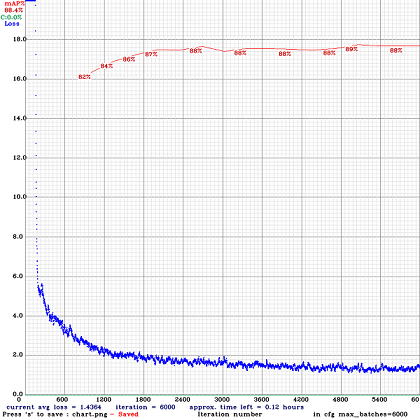

In [7]:
!pwd

/content/darknet


In [8]:
# 가중치 파일 로드
!gdown --id 1t1IxhLkGlCf8rQy-OgmkrytBDVbHSmiZ --output weight.zip

Downloading...
From: https://drive.google.com/uc?id=1t1IxhLkGlCf8rQy-OgmkrytBDVbHSmiZ
To: /content/darknet/weight.zip
237MB [00:03, 65.5MB/s]


In [9]:
# zip 파일 압축풀기
!unzip weight.zip

Archive:  weight.zip
  inflating: obj.data                
 extracting: obj.names               
  inflating: yolov4.cfg              
  inflating: yolov4-face_best.weights  


In [10]:
# yolov4를 구동하기 위한 필요 파일 복사하기
%cd /content/darknet
!cp yolov4.cfg ./cfg/yolov4-obj.cfg
!cp obj.data ./cfg/obj.data
!cp obj.names ./data/obj.names
!cp yolov4-face_best.weights ./cfg/yolov4_cam.weights

/content/darknet


# Step3. Webcam

In [11]:
!gdown --id 1-2QsB_5n1HrWrPRGgYHalNfLZUnhLXOg --output helpfunction.py 

Downloading...
From: https://drive.google.com/uc?id=1-2QsB_5n1HrWrPRGgYHalNfLZUnhLXOg
To: /content/darknet/helpfunction.py
100% 7.60k/7.60k [00:00<00:00, 6.61MB/s]


## Webcam 열기

In [12]:
from helpfunction import *

## yolov4 모델을 웹캠에 적용하기 위한 함수

In [13]:
!cd /content/darknet/

In [14]:
# 디텍션을 위한 함수 호출하기 
from darknet import *

# yolov4 아키텍처를 위한 네트위크 불러오기
network, class_names, class_colors = load_network("cfg/yolov4-obj.cfg", "cfg/obj.data", "cfg/yolov4_cam.weights")
height = network_height(network)
width = network_width(network)

# detection을 위한 darknet_helper 함수 정의
def darknet_helper(img, width, height):
    darknet_image = make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height), 
                               interpolation=cv2.INTER_LINEAR) 

    # bounding box 의 사이즈 변환을 위한 비율 구하기
    img_height, img_width, _ = img.shape  
    width_ratio = img_width/width
    height_ratio = img_height/height

    # detection
    copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image)
    free_image(darknet_image)

    return detections, width_ratio, height_ratio

## 웹캠에 우리가 커스터마이징한 욜로 모델 적용

In [ ]:
# start streaming video from webcam video_stream()은 위에서 자바 스크립트로 웹캠을 켜는 함수
video_stream()
label_html = 'Detecting...'  # label for video 레이블 지정
bbox = ''    # overlay 층 초기 투명 설정
face_image_list=[] 

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # 웹캡에서 들어 오는 자바 스크립트를 OpenCV 이미지로 변환
    frame = js_to_image(js_reply["img"])

    # bounding box 를 그리기 위한 투명한 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 위에서 받아온 video frame으로 detection
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop 문을 통해 overlay 층의 bounding box 그리기
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (1,1,1), 1)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (20,200,70), 2)
      
      face_image_list.append(frame[top-5:bottom+5, left-5:right+5])  # face_recognition을 위한 cropping

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255  # 투명도 조절
    bbox_bytes = bbox_to_bytes(bbox_array)  # overlay 층 byte 형식으로 변환
    bbox = bbox_bytes  # 출력을 위해 bbox array 저장

In [ ]:
# yolo detection 을 통해서 얻은 얼굴 이미지의 갯수
len(face_image_list)

66

# Step4. yolo detection + face recognition

## face_recognition 라이브러리

In [ ]:
!pip install face-recognition

     |████████████████████████████████| 100.2MB 119kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=fa464f8a11ad7b53dfeb1a253c36644c8f0c2945299409b3d027feeb673c0c76
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import face_recognition as fr

## cropping 한 사진 확인


helpfunction.py 의 image_arrange 함수

    image_arrange(이미지 파일을 담은 리스트, 사진 한장의 크기))   

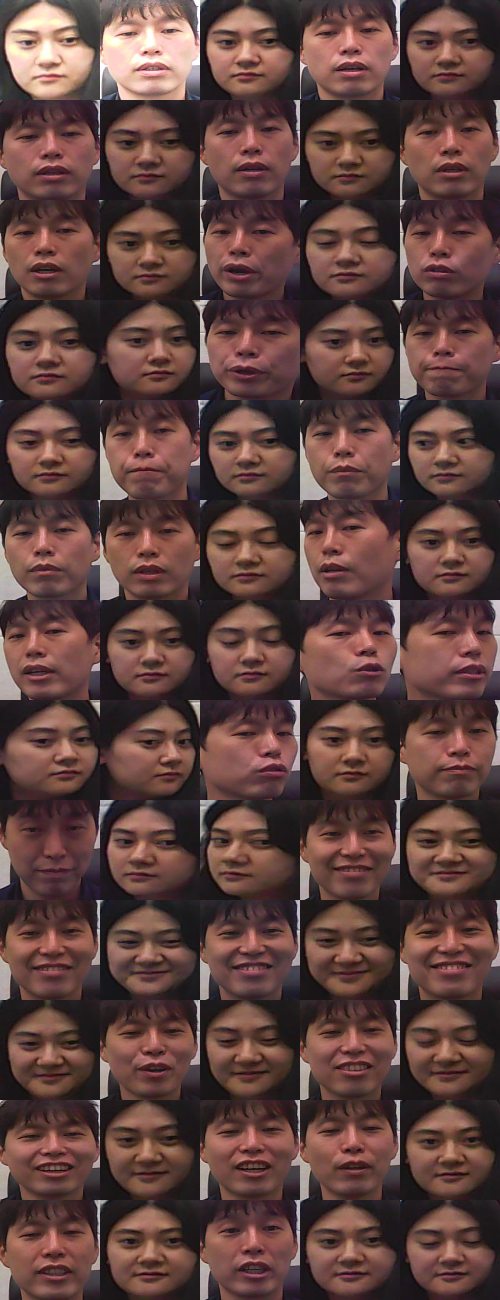

In [ ]:
cv2_imshow(image_arrange(face_image_list, 100))

## 유사도거리를 통한 분류

In [ ]:
k = 0
valid_face_image_list = []
for i in face_image_list:
        a = fr.face_encodings(i)
        if a==[]:
            pass  
        else:
            valid_face_image_list.append(i)

In [ ]:
len(valid_face_image_list)

63

[1.37524197]
added
[1.41501494 0.69590326]
added
[1.39209821 0.21581709 0.70092875]
[1.42975608 0.67760884 0.16865335]
[1.39349965 0.259821   0.70874122]
[1.4340733  0.6635022  0.19606874]
[1.40176663 0.2598898  0.70362188]
[1.42236356 0.65737328 0.21815106]
[1.41199409 0.2502255  0.72511843]
[1.41138963 0.64292346 0.24506381]
[1.41567794 0.62571941 0.25068718]
[1.38033427 0.23043437 0.71150639]
[1.3695425  0.63246175 0.28100548]
[1.3603348  0.31849101 0.69060366]
[1.42395019 0.64015384 0.31727869]
[1.40179355 0.29310655 0.72835518]
[1.34287899 0.27974331 0.6777276 ]
[1.36978679 0.65155943 0.32876338]
[1.35946361 0.31552973 0.67073625]
[1.38356731 0.66025937 0.39261458]
[1.39837469 0.27370996 0.72877253]
[1.38122496 0.63635574 0.37226004]
[1.41207512 0.26098098 0.74035267]
[1.41656661 0.66885484 0.32244208]
[1.39409851 0.26156531 0.69999672]
[1.42684121 0.64073527 0.30988593]
[1.40320606 0.64939931 0.24104573]
[1.40435325 0.30240632 0.71062338]
[1.38293199 0.61070922 0.3206999 ]
[1.375

2

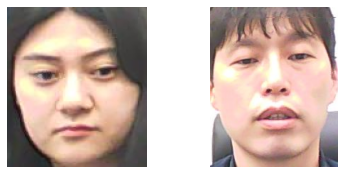

In [ ]:
# 초기 값 설정 
U1 = [np.zeros([128], dtype=np.uint8)]
fig = plt.figure(figsize=(10,10))
k = 1
a = create_dict(2) # 원하는 분류 인원
threshold = 0.49

for image in valid_face_image_list:
    try:
        unknown = fr.face_encodings(image)[0]
        face_distance = fr.face_distance(U1,unknown)
        print(face_distance)
        
        if any(face_distance<threshold):
            key = chr(ord('a')+np.argmin(face_distance)-1)
            value = a[key]
            value.append(unknown)
            a[key] = value
            pass
        else:
            print('added')
            fig.add_subplot(3,3,k)  
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            plt.axis('off')
            U1.append(unknown)
            key = chr(ord('a')+k-1)
            value = a[key]
            value.append(unknown)
            a[key] = value            
            
            k +=1

    except:
            continue
U1 = U1[1:]
len(U1)

In [ ]:
for i in a:
  print(len(a[i]))

33
30


## 특징점의 평균치로 대표값 설정

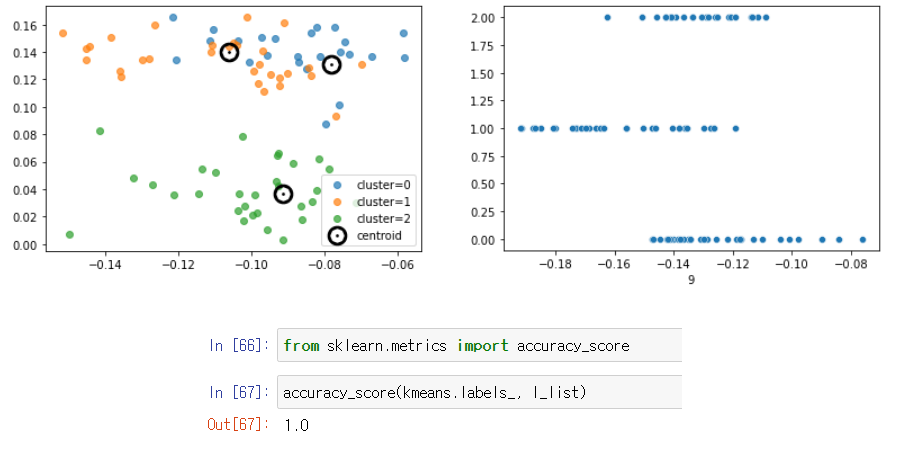

In [ ]:
a['a']

In [ ]:
# 분류된 이미지들의 특징점을 평균으로 대체
a_means = create_dict(len(a.keys()))
for i in a:
  d_list = np.array(a[i])
  a_means[i] = np.mean(d_list, axis=0)

In [ ]:
GroupA_f_encoding = [a_means['a'],a_means['b'] ]
label_list = ['A','B']
colour_list = [(255,0,0),(0,0,255)]

In [ ]:
GroupA_f_encoding

In [ ]:
# 자바 스크립트로 웹캠 켜기
video_stream()
label_html = 'Capturing...'  # label for video 레이블 지정
bbox = ''    # overlay 층 초기 투명 설정
face_image_list = []

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # 웹캡에서 들어 오는 자바 스크립트를 OpenCV 이미지로 변환
    frame = js_to_image(js_reply["img"])

    # bounding box 를 그리기 위한 투명한 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 위에서 받아온 video frame으로 detection
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop 문을 통해 overlay 층의 bounding box 그리기
    for label, confidence, bbox in detections:
      try:
          left, top, right, bottom = bbox2points(bbox)
          left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
          
          unknown = fr.face_encodings(frame[top-15:bottom+15, left-15:right+15])[0]    # cropping 한 이미지의 특징점 추출
          
          face_distance = fr.face_distance(GroupA_f_encoding,unknown)    # 지정한 그룹과 유사도 거리 측정
          
          num = np.argmin(face_distance)
          confidence = face_distance[num]
          label2 = label_list[num]   
          colour2 = colour_list[num]
          if confidence < threshold:
              bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), colour2, 2)
              bbox_array = cv2.putText(bbox_array, "{}".format(label2),
                            (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            colour2, 2)
          else:
              continue
  
      except:
          continue
           
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255  # 투명도 조절
    bbox_bytes = bbox_to_bytes(bbox_array)  # overlay 층 byte 형식으로 변환
    bbox = bbox_bytes  # 출력을 위해 bbox array 저장

<IPython.core.display.Javascript object>

## 피클 파일로 저장하기

In [ ]:
import pickle
# save
with open('A.pickle', 'wb') as f:
    pickle.dump(a_means['b'], f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# load
with open('A.pickle', 'rb') as f:
    A_face_encodings = pickle.load(f)

# Step5. 최종 구현

In [ ]:
# load
with open('/content/gdrive/MyDrive/face_pickle/A.pickle', 'rb') as f:
    A_face_encodings = pickle.load(f)

In [ ]:
# load
with open('/content/gdrive/MyDrive/face_pickle/H.pickle', 'rb') as f:
    B_face_encodings = pickle.load(f)

In [ ]:
label_list = ['A','B'] # 이름 설정 
colour_list = [(222,42,13),(13,222,56)]
GA_f_encoding = [A_face_encodings, B_face_encodings]

In [ ]:
GA_f_encoding

In [ ]:
# 자바 스크립트로 웹캠 켜기
video_stream()
label_html = 'Capturing...'  # label for video 레이블 지정
bbox = ''    # overlay 층 초기 투명 설정
face_image_list = []
threshold = 0.41

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # 웹캡에서 들어 오는 자바 스크립트를 OpenCV 이미지로 변환
    frame = js_to_image(js_reply["img"])

    # bounding box 를 그리기 위한 투명한 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    
    # 위에서 받아온 video frame으로 detection
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop 문을 통해 overlay 층의 bounding box 그리기
    for label, confidence, bbox in detections:
        left, top, right, bottom = bbox2points(bbox)
        left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
        unknown = fr.face_encodings(frame[top-10:bottom+10, left-10:right+10])
        if unknown == []:
            label2 = 'Take off your Mask'   
            colour2 = (255,255,255)
            p = 0.00
        else:
            face_distance = fr.face_distance(GA_f_encoding,unknown[0])
            num = np.argmin(face_distance)
            confidence = face_distance[num]

            if confidence < 0.29 :
                label2 = label_list[num]   
                colour2 = colour_list[num]
                p = 1.00

            elif confidence <= threshold :
                label2 = label_list[num]   
                colour2 = colour_list[num]
                p = 1/((0.2399*confidence/(threshold-0.3))-(0.0720/(threshold-0.3))+1.01)
            
            else:
                label2 = 'Unknown'   
                colour2 = (1,1,1)
                p = 0.00
                # continue

        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), (1,1,1), 1)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label2, float(p)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colour2, 2)
   
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255    # 투명도 조절
    bbox_bytes = bbox_to_bytes(bbox_array)    # overlay 층 byte 형식으로 변환
    bbox = bbox_bytes   # 출력을 위해 bbox array 저장

<IPython.core.display.Javascript object>